# Capstone Project: Starbucks use-case

## Data formatting and preparation

In [1]:
import pandas as pd
import numpy as np
import math
import json
import os

import matplotlib .pyplot as plt
%matplotlib inline

import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker import LinearLearner
from sagemaker.inputs import TrainingInput
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner
from sagemaker import image_uris

from sklearn.model_selection import train_test_split

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

print(portfolio.shape)
print(profile.shape)
print(transcript.shape)

(10, 6)
(17000, 5)
(306534, 4)


In [3]:
print(portfolio.columns)
print(profile.columns)
print(transcript.columns)

Index(['reward', 'channels', 'difficulty', 'duration', 'offer_type', 'id'], dtype='object')
Index(['gender', 'age', 'id', 'became_member_on', 'income'], dtype='object')
Index(['person', 'event', 'value', 'time'], dtype='object')


### Format portfolio file

In [4]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [5]:
# transform "channels" column (list type) into different columns

def to_dict(l):
    return {elem: True for elem in l}

channels = pd.DataFrame.from_dict(portfolio.channels.apply(to_dict).tolist()).fillna(False)
portfolio = pd.concat([portfolio, channels], axis=1).drop('channels', axis=1).set_index('id')
portfolio.head()

,reward,difficulty,duration,offer_type,email,mobile,social,web
id,,,,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,bogo,True,True,True,False
4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,bogo,True,True,True,True
3f207df678b143eea3cee63160fa8bed,0,0,4,informational,True,True,False,True
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,True,True,False,True
0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,discount,True,False,False,True


### Format profile file

In [6]:
print(profile.shape)

# this dataset contains NAs
profile.isna().sum()

# Let's remove them
profile.dropna(inplace=True)
profile.shape

(17000, 5)


(14825, 5)

In [7]:
profile['became_member_on'] = profile['became_member_on'].astype('str').astype('datetime64[ns]')

In [8]:
profile.head()

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0


In [9]:
# TODO bucket on age, became_member_on, income

### Format transcript file

Different types of events are available into `transcript.json` file:

In [10]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

For this use-case, we will ignore the `transactions`.

In order to centralize all the data we want to use for this use case into one single DataFrame, we first split the different event types into different DataFrames. 

In [11]:
offer_received = transcript[transcript.event == 'offer received']
offer_viewed = transcript[transcript.event == 'offer viewed']
transaction = transcript[transcript.event == 'transaction']
offer_completed = transcript[transcript.event == 'offer completed']

print(offer_received.shape)
print(offer_viewed.shape)
print(transaction.shape)
print(offer_completed.shape)

(76277, 4)
(57725, 4)
(138953, 4)
(33579, 4)


In [12]:
# for each dataframe, we have to transform the "value" column (dict type) into one or many clean Dataframe column(s). 
offer_received.loc[:, 'offer id'] = [d['offer id'] for d in offer_received.value.values.tolist()]
offer_received = offer_received.drop('value', axis=1).reset_index()

offer_viewed.loc[:, 'offer id'] = [d['offer id'] for d in offer_viewed.value.values.tolist()]
offer_viewed = offer_viewed.drop('value', axis=1).reset_index()

offer_completed.loc[:, 'offer id'] = [d['offer_id'] for d in offer_completed.value.values.tolist()]
offer_completed.loc[:, 'reward'] = [d['reward'] for d in offer_completed.value.values.tolist()]
offer_completed = offer_completed.drop('value', axis=1).reset_index()

transaction.loc[:, 'amount'] = [d['amount'] for d in transaction.value.values.tolist()]
transaction = transaction.drop('value', axis=1).reset_index()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [13]:
# One person can receive multiple times the same offer
offer_received[offer_received['person'] == '68be06ca386d4c31939f3a4f0e3dd783']

,index,person,event,time,offer id
12650,53174,68be06ca386d4c31939f3a4f0e3dd783,offer received,168,2906b810c7d4411798c6938adc9daaa5
25319,110828,68be06ca386d4c31939f3a4f0e3dd783,offer received,336,0b1e1539f2cc45b7b9fa7c272da2e1d7
38030,150596,68be06ca386d4c31939f3a4f0e3dd783,offer received,408,fafdcd668e3743c1bb461111dcafc2a4
50808,201570,68be06ca386d4c31939f3a4f0e3dd783,offer received,504,2298d6c36e964ae4a3e7e9706d1fb8c2
63512,245122,68be06ca386d4c31939f3a4f0e3dd783,offer received,576,fafdcd668e3743c1bb461111dcafc2a4


In [14]:
offer_completed[offer_completed['person'] == '68be06ca386d4c31939f3a4f0e3dd783']

,index,person,event,time,offer id,reward
24490,237365,68be06ca386d4c31939f3a4f0e3dd783,offer completed,552,fafdcd668e3743c1bb461111dcafc2a4,2
24491,237366,68be06ca386d4c31939f3a4f0e3dd783,offer completed,552,2298d6c36e964ae4a3e7e9706d1fb8c2,3


In [15]:
transaction[transaction['person'] == '68be06ca386d4c31939f3a4f0e3dd783']

,index,person,event,time,amount
59779,135224,68be06ca386d4c31939f3a4f0e3dd783,transaction,360,0.35
71171,167626,68be06ca386d4c31939f3a4f0e3dd783,transaction,414,0.74
78407,182544,68be06ca386d4c31939f3a4f0e3dd783,transaction,444,1.89
93184,218392,68be06ca386d4c31939f3a4f0e3dd783,transaction,510,5.04
98763,230411,68be06ca386d4c31939f3a4f0e3dd783,transaction,534,0.38
103014,237364,68be06ca386d4c31939f3a4f0e3dd783,transaction,552,2.12
115541,274519,68be06ca386d4c31939f3a4f0e3dd783,transaction,606,4.61
121381,283959,68be06ca386d4c31939f3a4f0e3dd783,transaction,630,0.06
135025,301915,68be06ca386d4c31939f3a4f0e3dd783,transaction,696,5.21


### Clean dataset

In [16]:
# create ids referencing person and offer ids
offer_received['person_offer id'] = offer_received['person'] + '_' + offer_received['offer id']
offer_viewed['person_offer id'] = offer_viewed['person'] + '_' + offer_viewed['offer id']
offer_completed['person_offer id'] = offer_completed['person'] + '_' + offer_completed['offer id']

In [17]:
# store ids for actions viewed and completed (= fully completed)
viewed_completed = set(offer_viewed['person_offer id']).intersection(set(offer_completed['person_offer id']))

# add a "completed" column to "offer_received" DataFrame
offer_received['completed'] = offer_received['person_offer id'].isin(viewed_completed)
clean_data = offer_received.set_index('person_offer id').drop(['index', 'time', 'event'], axis=1)

# add "reward" column from offer_completed
clean_data = clean_data.drop_duplicates().merge(offer_completed[['person_offer id', 'reward']].drop_duplicates().set_index('person_offer id'), on='person_offer id', how='left')

# add information about people and offers
clean_data = clean_data.reset_index()\
    .drop('reward', axis=1)\
    .merge(portfolio, how='left', left_on='offer id', right_on='id')\
    .merge(profile, how='inner', left_on='person', right_on='id')\
    .drop('id', axis=1)\
    .set_index('person_offer id')
clean_data.head(10)

,person,offer id,completed,reward,difficulty,duration,offer_type,email,mobile,social,web,gender,age,became_member_on,income
person_offer id,,,,,,,,,,,,,,,
78afa995795e4d85b5d9ceeca43f5fef_9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,True,5,5,7,bogo,True,True,False,True,F,75,2017-05-09,100000.0
78afa995795e4d85b5d9ceeca43f5fef_5a8bc65990b245e5a138643cd4eb9837,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,False,0,0,3,informational,True,True,True,False,F,75,2017-05-09,100000.0
78afa995795e4d85b5d9ceeca43f5fef_ae264e3637204a6fb9bb56bc8210ddfd,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,True,10,10,7,bogo,True,True,True,False,F,75,2017-05-09,100000.0
78afa995795e4d85b5d9ceeca43f5fef_f19421c1d4aa40978ebb69ca19b0e20d,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,True,5,5,5,bogo,True,True,True,True,F,75,2017-05-09,100000.0
e2127556f4f64592b11af22de27a7932_2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,False,2,10,7,discount,True,True,False,True,M,68,2018-04-26,70000.0
e2127556f4f64592b11af22de27a7932_3f207df678b143eea3cee63160fa8bed,e2127556f4f64592b11af22de27a7932,3f207df678b143eea3cee63160fa8bed,False,0,0,4,informational,True,True,False,True,M,68,2018-04-26,70000.0
e2127556f4f64592b11af22de27a7932_9b98b8c7a33c4b65b9aebfe6a799e6d9,e2127556f4f64592b11af22de27a7932,9b98b8c7a33c4b65b9aebfe6a799e6d9,True,5,5,7,bogo,True,True,False,True,M,68,2018-04-26,70000.0
e2127556f4f64592b11af22de27a7932_fafdcd668e3743c1bb461111dcafc2a4,e2127556f4f64592b11af22de27a7932,fafdcd668e3743c1bb461111dcafc2a4,True,2,10,10,discount,True,True,True,True,M,68,2018-04-26,70000.0
389bc3fa690240e798340f5a15918d5c_f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,True,5,5,5,bogo,True,True,True,True,M,65,2018-02-09,53000.0


In [18]:
# change categorical data to numeric data
num_data = clean_data.copy()

num_data[['completed', 'email', 'mobile', 'social', 'web']] = num_data[['completed', 'email', 'mobile', 'social', 'web']].astype(int)
num_data['offer_type'] = pd.factorize(num_data['offer_type'])[0]
num_data['gender'] = pd.factorize(num_data['gender'])[0]
num_data.head(10)

,person,offer id,completed,reward,difficulty,duration,offer_type,email,mobile,social,web,gender,age,became_member_on,income
person_offer id,,,,,,,,,,,,,,,
78afa995795e4d85b5d9ceeca43f5fef_9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,5,5,7,0,1,1,0,1,0,75,2017-05-09,100000.0
78afa995795e4d85b5d9ceeca43f5fef_5a8bc65990b245e5a138643cd4eb9837,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,0,0,0,3,1,1,1,1,0,0,75,2017-05-09,100000.0
78afa995795e4d85b5d9ceeca43f5fef_ae264e3637204a6fb9bb56bc8210ddfd,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,1,10,10,7,0,1,1,1,0,0,75,2017-05-09,100000.0
78afa995795e4d85b5d9ceeca43f5fef_f19421c1d4aa40978ebb69ca19b0e20d,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,1,5,5,5,0,1,1,1,1,0,75,2017-05-09,100000.0
e2127556f4f64592b11af22de27a7932_2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,2,10,7,2,1,1,0,1,1,68,2018-04-26,70000.0
e2127556f4f64592b11af22de27a7932_3f207df678b143eea3cee63160fa8bed,e2127556f4f64592b11af22de27a7932,3f207df678b143eea3cee63160fa8bed,0,0,0,4,1,1,1,0,1,1,68,2018-04-26,70000.0
e2127556f4f64592b11af22de27a7932_9b98b8c7a33c4b65b9aebfe6a799e6d9,e2127556f4f64592b11af22de27a7932,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,5,5,7,0,1,1,0,1,1,68,2018-04-26,70000.0
e2127556f4f64592b11af22de27a7932_fafdcd668e3743c1bb461111dcafc2a4,e2127556f4f64592b11af22de27a7932,fafdcd668e3743c1bb461111dcafc2a4,1,2,10,10,2,1,1,1,1,1,68,2018-04-26,70000.0
389bc3fa690240e798340f5a15918d5c_f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,1,5,5,5,0,1,1,1,1,1,65,2018-02-09,53000.0


In [19]:
# change became_member_on into number of months of fidelity
now = clean_data['became_member_on'].max()
print(now)

num_data['loyalty_in_months'] = num_data['became_member_on'].apply(lambda start_date: (now.year - start_date.year) * 12 + (now.month - start_date.month))
num_data.drop('became_member_on', axis=1, inplace=True)

num_data.head()

2018-07-26 00:00:00


,person,offer id,completed,reward,difficulty,duration,offer_type,email,mobile,social,web,gender,age,income,loyalty_in_months
person_offer id,,,,,,,,,,,,,,,
78afa995795e4d85b5d9ceeca43f5fef_9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,5,5,7,0,1,1,0,1,0,75,100000.0,14
78afa995795e4d85b5d9ceeca43f5fef_5a8bc65990b245e5a138643cd4eb9837,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,0,0,0,3,1,1,1,1,0,0,75,100000.0,14
78afa995795e4d85b5d9ceeca43f5fef_ae264e3637204a6fb9bb56bc8210ddfd,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,1,10,10,7,0,1,1,1,0,0,75,100000.0,14
78afa995795e4d85b5d9ceeca43f5fef_f19421c1d4aa40978ebb69ca19b0e20d,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,1,5,5,5,0,1,1,1,1,0,75,100000.0,14
e2127556f4f64592b11af22de27a7932_2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,2,10,7,2,1,1,0,1,1,68,70000.0,3


In [20]:
clean_data.shape

(55222, 15)

In [21]:
clean_data.columns

Index(['person', 'offer id', 'completed', 'reward', 'difficulty', 'duration',
       'offer_type', 'email', 'mobile', 'social', 'web', 'gender', 'age',
       'became_member_on', 'income'],
      dtype='object')

## Visualisations

<AxesSubplot:title={'center':'Completed offers (42.55 %)'}>

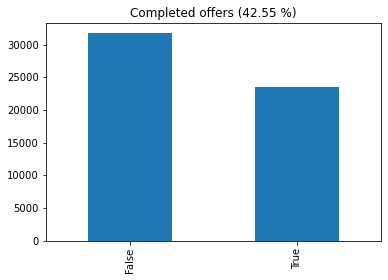

In [22]:
clean_data['completed'].value_counts().plot.bar(title='Completed offers (%.2f %%)' % ((clean_data.completed.sum() / clean_data.shape[0]) * 100))

<AxesSubplot:title={'center':'Offer types'}>

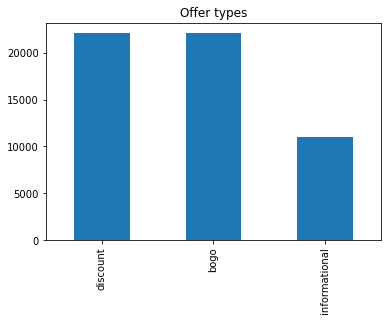

In [68]:
clean_data['offer_type'].value_counts().plot.bar(title='Offer types')

<AxesSubplot:xlabel='completed'>

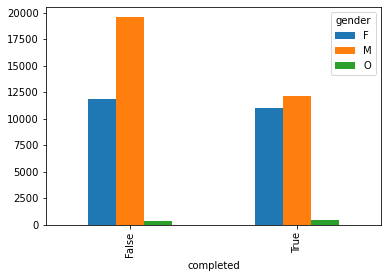

In [95]:
clean_data.groupby(['completed', 'gender']).size().unstack().plot(title='',kind='bar', stacked=False)

## Modeling

In [23]:
# storing SageMaker variables
# sagemaker session, role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket name
bucket = sagemaker_session.default_bucket()

In [37]:
# train test split
X = num_data[['reward', 'difficulty', 'duration', 'offer_type', 'email', 'mobile', 'social', 'web', \
                'gender', 'age', 'loyalty_in_months', 'income']].to_numpy()
y = num_data['completed'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.5, random_state=42)
X_train.shape, X_val.shape, X_test.shape

((33133, 12), (11045, 12), (11044, 12))

In [38]:
# check data types
type(X_train)

numpy.ndarray

In [39]:
y_train

array([1, 0, 0, ..., 1, 0, 0])

### Benchmark model: LinearLearner

In [40]:
# specify an output path
prefix = 'starbucks_benchmark'
output_path = 's3://{}/{}'.format(bucket, prefix)

# instantiate LinearLearner
linear = LinearLearner(role=role,
                       train_instance_count=1, 
                       train_instance_type='ml.c4.xlarge',
                       predictor_type='binary_classifier',
                       output_path=output_path,
                       sagemaker_session=sagemaker_session,
                       epochs=15)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [41]:
# create train RecordSet
train_recordset = linear.record_set(X_train.astype('float32'), labels=y_train.astype('float32'))

In [42]:
%%time
# train the estimator
linear.fit(train_recordset)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-07-05 18:46:04 Starting - Starting the training job...
2021-07-05 18:46:06 Starting - Launching requested ML instancesProfilerReport-1625510763: InProgress
...
2021-07-05 18:47:02 Starting - Preparing the instances for training.........
2021-07-05 18:48:34 Downloading - Downloading input data...
2021-07-05 18:49:02 Training - Downloading the training image...
2021-07-05 18:49:34 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/05/2021 18:49:27 INFO 140529176573760] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': '

In [43]:
%%time 

# deploy the model in order to use it to predict
linear_predictor = linear.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-----------------!CPU times: user 404 ms, sys: 20.9 ms, total: 425 ms
Wall time: 8min 32s


In [44]:
# use the deployed estimator to predict on test data
predicted = linear_predictor.predict(X_test.astype('float32'))
predicted

[label {
   key: "predicted_label"
   value {
     float32_tensor {
       values: 0.0
     }
   }
 }
 label {
   key: "score"
   value {
     float32_tensor {
       values: 0.04048098251223564
     }
   }
 },
 label {
   key: "predicted_label"
   value {
     float32_tensor {
       values: 0.0
     }
   }
 }
 label {
   key: "score"
   value {
     float32_tensor {
       values: 0.05883850157260895
     }
   }
 },
 label {
   key: "predicted_label"
   value {
     float32_tensor {
       values: 1.0
     }
   }
 }
 label {
   key: "score"
   value {
     float32_tensor {
       values: 0.7622645497322083
     }
   }
 },
 label {
   key: "predicted_label"
   value {
     float32_tensor {
       values: 0.0
     }
   }
 }
 label {
   key: "score"
   value {
     float32_tensor {
       values: 0.02330854907631874
     }
   }
 },
 label {
   key: "predicted_label"
   value {
     float32_tensor {
       values: 0.0
     }
   }
 }
 label {
   key: "score"
   value {
     float32_tensor

In [45]:
y_pred = np.array([elem.label['predicted_label'].float32_tensor.values[0] for elem in predicted])

In [46]:
# evaluate
def evaluate(test_labels, test_preds):
    
    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(test_labels, test_preds).sum()
    fp = np.logical_and(1-test_labels, test_preds).sum()
    tn = np.logical_and(1-test_labels, 1-test_preds).sum()
    fn = np.logical_and(test_labels, 1-test_preds).sum()
    
    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
        
    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn, 
            'Precision': precision, 'Recall': recall, 'Accuracy': accuracy} 

In [47]:
evaluate(y_test, y_pred)

{'TP': 3506,
 'FP': 1867,
 'FN': 1172,
 'TN': 4499,
 'Precision': 0.6525218686022706,
 'Recall': 0.7494655835827276,
 'Accuracy': 0.7248279608837378}

In [48]:
# delete endpoint
linear_predictor.delete_endpoint()

#### Favor the recall

Here, we want to maximise the recall. Indeed, what is important for this use-case is to successfully reach a maximum of Starbucks customers. Moreover, this is not a too big deal if some offers are sent, but not completed. These 2 points let us think that we should favor recall, and not precision here. 

Let's train a LinearLearner taking that into account, and see if this increases our recall. 

In [49]:
# instantiate LinearLearner
linear_recall = LinearLearner(role=role,
                       train_instance_count=1, 
                       train_instance_type='ml.c4.xlarge',
                       predictor_type='binary_classifier',
                       output_path=output_path,
                       sagemaker_session=sagemaker_session,
                       epochs=15,
                       binary_classifier_model_selection_criteria='precision_at_target_recall', # target recall
                       target_recall=0.85) # 85% recall


# train the estimator
linear_recall.fit(train_recordset)

# deploy the model in order to use it to predict
linear_predictor_recall = linear_recall.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

# use the deployed estimator to predict on test data
predicted_recall = linear_predictor_recall.predict(X_test.astype('float32'))
predicted_recall

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-07-05 18:58:54 Starting - Starting the training job...
2021-07-05 18:59:17 Starting - Launching requested ML instancesProfilerReport-1625511534: InProgress
...
2021-07-05 18:59:52 Starting - Preparing the instances for training.........
2021-07-05 19:01:18 Downloading - Downloading input data...
2021-07-05 19:01:51 Training - Downloading the training image...
2021-07-05 19:02:18 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/05/2021 19:02:15 INFO 139650899572544] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': '

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


Training seconds: 79
Billable seconds: 79
-----------------!

[label {
   key: "predicted_label"
   value {
     float32_tensor {
       values: 0.0
     }
   }
 }
 label {
   key: "score"
   value {
     float32_tensor {
       values: 0.04048098251223564
     }
   }
 },
 label {
   key: "predicted_label"
   value {
     float32_tensor {
       values: 0.0
     }
   }
 }
 label {
   key: "score"
   value {
     float32_tensor {
       values: 0.05883850157260895
     }
   }
 },
 label {
   key: "predicted_label"
   value {
     float32_tensor {
       values: 1.0
     }
   }
 }
 label {
   key: "score"
   value {
     float32_tensor {
       values: 0.7622645497322083
     }
   }
 },
 label {
   key: "predicted_label"
   value {
     float32_tensor {
       values: 0.0
     }
   }
 }
 label {
   key: "score"
   value {
     float32_tensor {
       values: 0.02330854907631874
     }
   }
 },
 label {
   key: "predicted_label"
   value {
     float32_tensor {
       values: 1.0
     }
   }
 }
 label {
   key: "score"
   value {
     float32_tensor

In [50]:
# evaluation
y_pred_recall = np.array([elem.label['predicted_label'].float32_tensor.values[0] for elem in predicted_recall])

evaluate(y_test, y_pred_recall)

{'TP': 3955,
 'FP': 2380,
 'FN': 723,
 'TN': 3986,
 'Precision': 0.6243093922651933,
 'Recall': 0.8454467721248397,
 'Accuracy': 0.7190329590727997}

In [51]:
# delete endpoint
linear_predictor_recall.delete_endpoint()

### Advanced model: XGBoost model

#### The simple version

In [63]:
data_dir = 'data/xgboost'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [57]:
# store datasets into csv files, locally
pd.DataFrame(X_test).to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

pd.concat([pd.Series(y_val), pd.DataFrame(X_val)], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([pd.Series(y_train), pd.DataFrame(X_train)], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

In [59]:
# S3 prefix (which folder will we use)
xgb_prefix = 'starbucks_xgboost'

test_location = sagemaker_session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=xgb_prefix)
val_location = sagemaker_session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=xgb_prefix)
train_location = sagemaker_session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=xgb_prefix)

In [60]:
output_path = 's3://{}/{}'.format(bucket, xgb_prefix)
xgboost_container = sagemaker.image_uris.retrieve("xgboost", sagemaker_session.boto_region_name, "1.2-2")

In [66]:
# define hyperparameters
hyperparams = {
    "max_depth":5,
    "subsample":0.8,
    "num_round":300,
    "early_stopping_rounds":10,
    "eta":0.2,
    "gamma":4,
    "min_child_weight":6,
    "objective":'binary:logistic',
    "eval_metric":'auc'
}

# define the estimator
xgb_estimator = sagemaker.estimator.Estimator(image_uri=xgboost_container, 
                                          hyperparameters=hyperparams,
                                          role=role,
                                          sagemaker_session=sagemaker_session,
                                          instance_count=1, 
                                          instance_type='ml.m5.2xlarge', 
                                          volume_size=5, # 5 GB 
                                          output_path=output_path)


# get s3 locations for train and validation sets
s3_input_train = TrainingInput(s3_data=train_location, content_type='csv')
s3_input_validation = TrainingInput(s3_data=val_location, content_type='csv')

# fit estimator
xgb_estimator.fit({'train': s3_input_train, 'validation': s3_input_validation})

2021-07-05 19:26:28 Starting - Starting the training job...
2021-07-05 19:26:51 Starting - Launching requested ML instancesProfilerReport-1625513187: InProgress
......
2021-07-05 19:27:51 Starting - Preparing the instances for training......
2021-07-05 19:28:54 Downloading - Downloading input data...
2021-07-05 19:29:12 Training - Downloading the training image...
2021-07-05 19:29:55 Uploading - Uploading generated training model
2021-07-05 19:29:55 Completed - Training job completed
[2021-07-05 19:29:42.801 ip-10-2-83-1.ec2.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-07-05:19:29:42:INFO] Imported framework sagemaker_xgboost_container.training
[2021-07-05:19:29:42:INFO] Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
[2021-07-05:19:29:42:INFO] Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
[2021-07-05:19:29:42:INFO] No GPUs detected (normal if no gpus installed)
[2021

In [67]:
# create a transformer in order to predict
xgb_transformer = xgb_estimator.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')
xgb_transformer.wait()

......................................[2021-07-05:19:37:43:INFO] No GPUs detected (normal if no gpus installed)
[2021-07-05:19:37:43:INFO] No GPUs detected (normal if no gpus installed)
[2021-07-05:19:37:43:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout 3;

    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }

    location / {
      return 404 "{}";
    }

  }
}


[2021-07-05 19:37:44 +0000] [19] [I

In [69]:
# get predictions back from S3
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-1-326763253251/sagemaker-xgboost-2021-07-05-19-31-30-574/test.csv.out to data/xgboost/test.csv.out


In [71]:
# read predictions
xgb_predictions = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)
xgb_predictions = [round(num) for num in xgb_predictions.squeeze().values]

[0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,


In [75]:
evaluate(y_test, np.array(xgb_predictions))

{'TP': 3323,
 'FP': 1193,
 'FN': 1355,
 'TN': 5173,
 'Precision': 0.7358281665190434,
 'Recall': 0.7103463018383924,
 'Accuracy': 0.7692864904020282}

#### Hyperparameter tuning (GridSearch)

In [88]:
# define the estimator
xgb_estimator_gs = sagemaker.estimator.Estimator(image_uri=xgboost_container, 
                                          hyperparameters=hyperparams,
                                          role=role,
                                          sagemaker_session=sagemaker_session,
                                          instance_count=1, 
                                          instance_type='ml.m5.2xlarge', 
                                          volume_size=5, # 5 GB 
                                          output_path=output_path)

# define the hyperparameter tuner
xgb_hyperparameter_tuner = HyperparameterTuner(estimator = xgb_estimator_gs,
                                               objective_metric_name = 'validation:rmse', 
                                               objective_type = 'Minimize', 
                                               max_jobs = 24, # The total number of models to train
                                               max_parallel_jobs = 6, # The number of models to train in parallel
                                               hyperparameter_ranges = {
                                                    'max_depth': IntegerParameter(3, 12),
                                                    'eta'      : ContinuousParameter(0.05, 0.5),
                                                    'min_child_weight': IntegerParameter(2, 8),
                                                    'subsample': ContinuousParameter(0.5, 0.9),
                                                    'gamma': ContinuousParameter(0, 10),
                                               })

# fit the hyperparameter tuner
xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})
xgb_hyperparameter_tuner.wait()

...............................................................................................................................................!
!


In [89]:
# Once hyperparameter tuning is over, we can create a new estimator by using optimal hyperparameters
xgb_attached = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner.best_training_job())


2021-07-05 20:39:58 Starting - Preparing the instances for training
2021-07-05 20:39:58 Downloading - Downloading input data
2021-07-05 20:39:58 Training - Training image download completed. Training in progress.
2021-07-05 20:39:58 Uploading - Uploading generated training model
2021-07-05 20:39:58 Completed - Training job completed


In [90]:
# let's then create a transformer in order to predict
xgb_transformer_gs = xgb_attached.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')
xgb_transformer_gs.transform(test_location, content_type='text/csv', split_type='Line')
xgb_transformer_gs.wait()

..................................[2021-07-05:20:50:31:INFO] No GPUs detected (normal if no gpus installed)
[2021-07-05:20:50:31:INFO] No GPUs detected (normal if no gpus installed)
[2021-07-05:20:50:31:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout 3;

    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }

    location / {
      return 404 "{}";
    }

  }
}


[2021-07-05 20:50:31 +0000] [20] [INFO]

In [91]:
# get predictions back from S3
!aws s3 cp --recursive $xgb_transformer_gs.output_path $data_dir

download: s3://sagemaker-us-east-1-326763253251/sagemaker-xgboost-2021-07-05-20-45-00-653/test.csv.out to data/xgboost/test.csv.out


In [92]:
# read predictions
xgb_predictions_gs = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)
xgb_predictions_gs = [round(num) for num in xgb_predictions_gs.squeeze().values]

In [93]:
evaluate(y_test, np.array(xgb_predictions_gs))

{'TP': 3320,
 'FP': 1169,
 'FN': 1358,
 'TN': 5197,
 'Precision': 0.7395856538204499,
 'Recall': 0.7097050021376656,
 'Accuracy': 0.7711879753712423}

In [ ]:
# First we will remove all of the files contained in the data_dir directory
!rm $data_dir/*

# And then we delete the directory itself
!rmdir $data_dir

# Similarly we will remove the files in the cache_dir directory and the directory itself
!rm $cache_dir/*
!rmdir $cache_dir